In [11]:
import numpy as np
import pandas as pd
import datetime
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

warnings.filterwarnings("ignore")

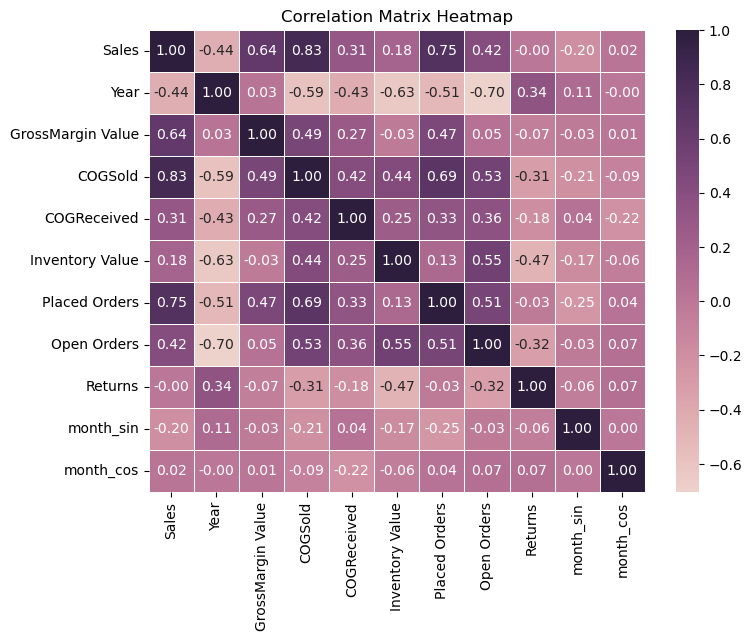

In [ ]:
#the Dataframe
df = pd.read_excel("Model_Dataset.xlsx")
#Clean df and convert month data to integer and then cycle patterned data. 
df['Month'] = pd.to_datetime(df['Month'], format='%b').dt.month
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)
df = df.drop(columns='Month')
#Correlation Matrix 
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
rocket_cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=rocket_cmap, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [6]:
#Dataframe split with scaling code
X = df.drop(['Sales'],axis=1)
y = df['Sales']
#split target variable and scale
split_year = 2025
train_df = df[df['Year'] < split_year]
test_df = df[df['Year'] >= split_year]

X_train = train_df.drop(['Sales'], axis=1)
# Training target
y_train = train_df['Sales']

# Testing features (all columns except 'Sales')
X_test = test_df.drop(['Sales'], axis=1)
# Testing target
y_test = test_df['Sales']

#Scale dataframe
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Best iteration found: 12
Test RMSE with early stopping: 185643.61


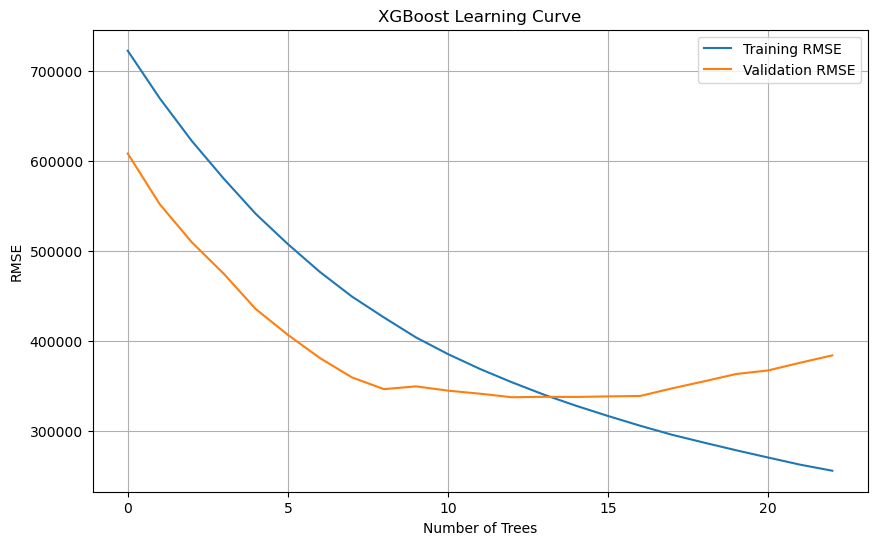

In [139]:
# Create a validation set from the training data for early stopping
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
) # 0.25 of training set is 20% of full dataset

# Initialize XGBoost model with early stopping
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # A large number to allow early stopping
    early_stopping_rounds=10, # Stop if validation error doesn't improve for 10 rounds
    learning_rate=0.12,
    max_depth=4,
    min_child_weight=3,
    colsample_bynode=1,
    reg_lambda=1,
    random_state=42
)

# Train the model with an evaluation set and early stopping
xgbr.fit(
    X_train_val,
    y_train_val,
    eval_set=[(X_val, y_val)],
    verbose=False             # Set to True to see evaluation logs
)

print(f"Best iteration found: {xgbr.best_iteration}")

# Make predictions on the original test set using the best model
y_pred_test = xgbr.predict(X_test, iteration_range=(0, xgbr.best_iteration))

# Evaluate the model
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"Test RMSE with early stopping: {rmse_test:.2f}")

# Train the model with verbose output to plot results later
eval_set = [(X_train_val, y_train_val), (X_val, y_val)]
xgbr.fit(
    X_train_val,
    y_train_val,
    eval_set=eval_set,
    verbose=False  # Set to True to see the logs during training
)

# Retrieve evaluation results
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Training RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.title('XGBoost Learning Curve')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
pd.options.display.float_format = '{:,.2f}'.format
y_pred = np.round(y_pred_test, decimals=0)
pred_test_df = pd.DataFrame(y_pred, columns = ['Prediction'])
test_df_ = pd.DataFrame(y_test).reset_index(drop=True)
pred_test_df = pd.concat([pred_test_df,test_df_],axis=1)
index = pd.DataFrame(['jan','feb','mar','apr','may','jun','jul'])
pred_test_df = pd.concat([pred_test_df,index],axis=1).set_index(0)
pred_test_df['Difference'] = pred_test_df['Prediction']-pred_test_df['Sales']
pred_test_df

,Prediction,Sales,Difference
0,,,
jan,"1,341,256.00","1,689,630.57","-348,374.57"
feb,"967,129.00","875,660.25","91,468.75"
mar,"1,672,028.00","1,668,320.56","3,707.44"
apr,"1,530,815.00","1,250,591.02","280,223.98"
may,"1,380,363.00","1,486,397.37","-106,034.37"
jun,"1,530,815.00","1,665,250.34","-134,435.34"
jul,"1,914,993.00","1,854,510.46","60,482.54"


In [ ]:
#comparison between actuals and submitted LRBP plan
raw_values = "$1,711	$876	$1,840	$1,279	$1,739	$1,687	$1,913"
LRBP_predict_v = "$1,300	$1,300	$1,300	$1,500	$1,500	$1,500	$1,500"

actuals_list = [
    int(v.replace('$', '').replace(',', ''))
    for v in raw_values.split('\t')
]

LRBP_predict_list = [
    int(v.replace('$', '').replace(',', ''))
    for v in LRBP_predict_v.split('\t')
]

df_LRBP_comp = pd.DataFrame({
    'actuals': actuals_list,
    'LRBP_predict': LRBP_predict_list
})
df_LRBP_comp['difference']=df_LRBP_comp['actuals']-df_LRBP_comp['LRBP_predict']
df_LRBP_comp

,actuals,LRBP_predict,difference
0,1711,1300,411
1,876,1300,-424
2,1840,1300,540
3,1279,1500,-221
4,1739,1500,239
5,1687,1500,187
6,1913,1500,413
